# Approximate NMDA dynamics

In this notebook, we will describe the approximation we employ, and compare the dynamics to the exact implementation. The full sub-threshold dynamics are given by the following equations

$$\begin{align}
    I_\mathrm{syn}(t) &= 
    + I_\mathrm{rec, AMPA}(t) 
    + I_\mathrm{rec, NMDA}(t) 
    + I_\mathrm{rec, GABA}(t) \mathrm{,}\\[1.5ex]
    I_\mathrm{ext,AMPA} &= g_\mathrm{ext,AMPA}(V(t) - V_E)S_{j,\mathrm{ext, AMPA}}(t)\mathrm{,}\\
    I_\mathrm{rec,AMPA} &= g_\mathrm{rec,AMPA}(V(t) - V_E)\sum_{j=1}^{N_E}w_jS_{j,\mathrm{rec,AMPA}}(t) \mathrm{,}\\
    I_\mathrm{rec,NMDA} &= \frac{g_\mathrm{rec,NMDA}(V(t) - V_E)}{1+[\mathrm{Mg^{2+}}]\mathrm{exp}(-0.062V(t))/3.57}\sum_{j=1}^{N_E}w_jS_{j,\mathrm{NMDA}}(t) \mathrm{,}\\
    I_\mathrm{rec,GABA} &= g_\mathrm{rec,GABA}(V(t) - V_E)\sum_{j=1}^{N_E}w_jS_{j,\mathrm{GABA}}(t) \mathrm{.}
\end{align}
$$

where the variables $S_{j,\mathrm{ext,AMPA}},S_{j,\mathrm{rec,AMPA}},S_{j,\mathrm{NMDA}},\ \mathrm{ and }\ S_{j,\mathrm{GABA}}$
are governed by the equations

$$\begin{align}
    \frac{dS_{j,\mathrm{AMPA}}}{dt} &= -\frac{S_{j,\mathrm{AMPA}}}{\tau_\mathrm{AMPA}}+\sum_k \delta (t - t_j^k) \mathrm{,} \\
    \frac{dS_{j,\mathrm{GABA}}}{dt} &= -\frac{S_{j,\mathrm{GABA}}}{\tau_\mathrm{GABA}} + \sum_k \delta (t - t_j^k) \mathrm{,} \\
    \frac{dS_{j,\mathrm{NMDA}}}{dt} &= -\frac{S_{j,\mathrm{NMDA}}}{\tau_\mathrm{NMDA,decay}}+ \alpha x_j (1 - S_{j,\mathrm{NMDA}})\mathrm{,}\\
    \frac{dx_j}{dt} &= - \frac{x_j}{\tau_\mathrm{NMDA,rise}} + \sum_k \delta (t - t_j^k) \mathrm{.}
\end{align}
$$

We will from now on only focus on the last two equations, which are the subjects of the approximation in the model. We drop the subscript NMDA in the following. Between spikes, plugging in the solution for $x$ on the interval $[0, t]$, we get the following equation for $S_j$
$$
\begin{align}
    \frac{dS_{j}}{dt} + \bigg(\frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}}\bigg] \bigg) S_{j,\mathrm{NMDA}} &= \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}}\bigg] \mathrm{,}
\end{align}
$$
for which the formal solution can easily be found by an integrating factor:
$$
    S_{j}(t)  = \mathrm{exp}\Bigg[-\int_0^t \frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] dt' \Bigg] 
    \Bigg( \int_0^t \mathrm{exp}\Bigg[\int_0^{t'} \frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t''}{\tau_\mathrm{r}} \bigg] dt'' \Bigg]\alpha x_j^0 \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}}\bigg] dt' + S_{j}^0 \Bigg) \mathrm{.}
$$

The first and innermost integrals can be solved, which gives
$$
    S_{j}(t) 
    = 
    \mathrm{exp}\Bigg[-\frac{t}{\tau_\mathrm{d}} - \alpha x_j^{k-1} \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg( \int_0^{t} \mathrm{exp}\Bigg[(t') \bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) + \alpha x_j^0 \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]\alpha x_j^0 dt' + S_{j}^0 \Bigg) \mathrm{.}
$$

Since we have two different time scales in the exponential inside the remaining integral, there is no exact solution for arbitrary limits of integration. We would like to approximate this function with an exponential function, such that we can integrate the sum of multiple such functions in a single variable. Our approximate function will then have the form 
$$
\hat{S_j} (t) = S_\mathrm{jump} \mathrm{exp}\Big(-\frac{t}{\tau_d}\Big)
$$
between spikes, where $S_\mathrm{jump}$ is some initial condition immediately after receiving a spike. We set the value of $S_\mathrm{jump}$ such that the approximation is exact in the limit as $t \to \infty$, in the sense that their ratio approaches unity. We additionally make the assumption that $x_0 = 0$ immediately before every spikes. Since $\tau_r$ is very small (e.g. $2 ms$), this is reasonable unless the neuron is firing very rapidly.

Setting $x_0 = 1$ in the exact solution upon spiking, we then get
$$\begin{align}
    S_\mathrm{jump} \mathrm{exp}\Big(-\frac{t}{\tau_d}\Big)
    &=
    \mathrm{exp}\Bigg[-\frac{t}{\tau_\mathrm{d}} - \alpha \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg( \int_0^{t} \mathrm{exp}\Bigg[(t') \bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) + \alpha \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]\alpha dt' + S_{j}^0 \Bigg) \mathrm{,} \\
    S_\mathrm{jump}
    &=
    \mathrm{exp}\Bigg[- \alpha x_j^{k-1} \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg( \int_0^{t} \mathrm{exp}\Bigg[(t') \bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) + \alpha \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]\alpha dt' + S_{j}^0 \Bigg)
\end{align}
$$
and taking the limit, we get
$$\begin{align}
    S_\mathrm{jump} = 
    \mathrm{exp}\Big[-\alpha \tau_\mathrm{r}\Big] S_0
    - 
    \alpha \tau_\mathrm{r} \mathrm{ExpE}\Big[\frac{\tau_\mathrm{r}}{\tau_\mathrm{d}}, \alpha \tau_\mathrm{r} \Big] 
    +
    (\alpha \tau_\mathrm{r})^\frac{\tau_\mathrm{r}}{\tau_\mathrm{d}}\mathrm{Gamma}\Big[1 - \frac{\tau_\mathrm{r}}{\tau_\mathrm{d}}\Big] \mathrm{,}
\end{align}
$$
where $S_0$ is the initial condition of $S$ in the exact solution.

After spiking, the new value of $S$ is then dependent only on the value of $S$ immediately before spiking. In pre-synaptic neurons, every time a spike occurs, the value of $S_0$ immediately before spiking is computed. $\Delta S = S_\mathrm{jump} - S_0$ is then computed, and sent to post-synaptic neurons as an offset in the SpikeEvent object. The post-synaptic neuron then adds the offset multiplied by weight and multiplicity to its $s_\mathrm{NMDA}$ variable. Integration in the post-synaptic neuron is then done as a normal exponential synapse.

In [1]:
import nest
import matplotlib.pyplot as plt

import numpy as np


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Feb 15 2024 17:55:17

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
w_ext = 40.
w_ex = 1.
w_in = 15.

params = {"tau_AMPA": 2.0,
          "tau_GABA": 5.0,
          "tau_rise_NMDA": 2.0,
          "tau_decay_NMDA": 100.0,
          "conc_Mg2": 1.0,
          "E_ex": 0.0,
          "E_in": -70.0,
          "E_L": -70.0,
          "V_th": -55.0,
          "C_m": 500.0,
          "g_L": 25.0,
          "V_reset": -70.0,
          "alpha": 0.5,
          "t_ref": 2.0}

We create 1 pre-synaptic approximate neuron, 1 post-synaptic approximate and 1 post-synaptic exact neuron. Stimulating the pre-synaptic neuron, we will compare the synaptic variables and membrane potential in the approximate and exact post-synaptic neurons.

In [3]:
nest.ResetKernel()
nest.rng_seed = 12345

# pre-synaptic neuron, must be approximate model since the post-synaptic approximate model needs the offset
nrn1 = nest.Create("iaf_wang_2002", params)
nrn2 = nest.Create("iaf_wang_2002", params)
nrn3 = nest.Create("iaf_wang_2002_exact", params)

pg = nest.Create("poisson_generator", {"rate": 50.})
# since we're "abusing" spike offset, set time_in_steps to True and multiply by resolution after
sr = nest.Create("spike_recorder", {"time_in_steps": True})

mm1 = nest.Create("multimeter", {"record_from": ["V_m", "s_AMPA", "s_NMDA", "s_GABA"], "interval": 0.1})
mm2 = nest.Create("multimeter", {"record_from": ["V_m", "s_AMPA", "s_NMDA", "s_GABA"], "interval": 0.1})
mm3 = nest.Create("multimeter", {"record_from": ["V_m", "s_AMPA", "s_NMDA", "s_GABA"], "interval": 0.1})

ampa_ext_syn_spec = {"synapse_model": "static_synapse",
                     "weight": w_ext,
                     "receptor_type": 1}

ampa_syn_spec = {"synapse_model": "static_synapse",
               "weight": w_ex,
               "receptor_type": 1}

nmda_syn_spec = {"synapse_model": "static_synapse",
               "weight": w_ex,
               "receptor_type": 3}

gaba_syn_spec = {"synapse_model": "static_synapse",
               "weight": w_in,
               "receptor_type": 2}

nest.Connect(pg, nrn1, syn_spec=ampa_ext_syn_spec)
nest.Connect(nrn1, sr)
nest.Connect(nrn1, nrn2, syn_spec=ampa_syn_spec)
nest.Connect(nrn1, nrn2, syn_spec=gaba_syn_spec)
nest.Connect(nrn1, nrn2, syn_spec=nmda_syn_spec)
nest.Connect(nrn1, nrn3, syn_spec=ampa_syn_spec)
nest.Connect(nrn1, nrn3, syn_spec=gaba_syn_spec)
nest.Connect(nrn1, nrn3, syn_spec=nmda_syn_spec)
nest.Connect(mm1, nrn1)

nest.Connect(mm2, nrn2)
nest.Connect(mm3, nrn3)

nest.Simulate(1000.)


Feb 19 12:31:55 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.

Feb 19 12:31:55 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.

Feb 19 12:31:55 NodeManager::prepare_nodes [Info]: 
    Preparing 8 nodes for simulation.

Feb 19 12:31:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Feb 19 12:31:55 SimulationManager::run [Info]: 
    Simulation finished.


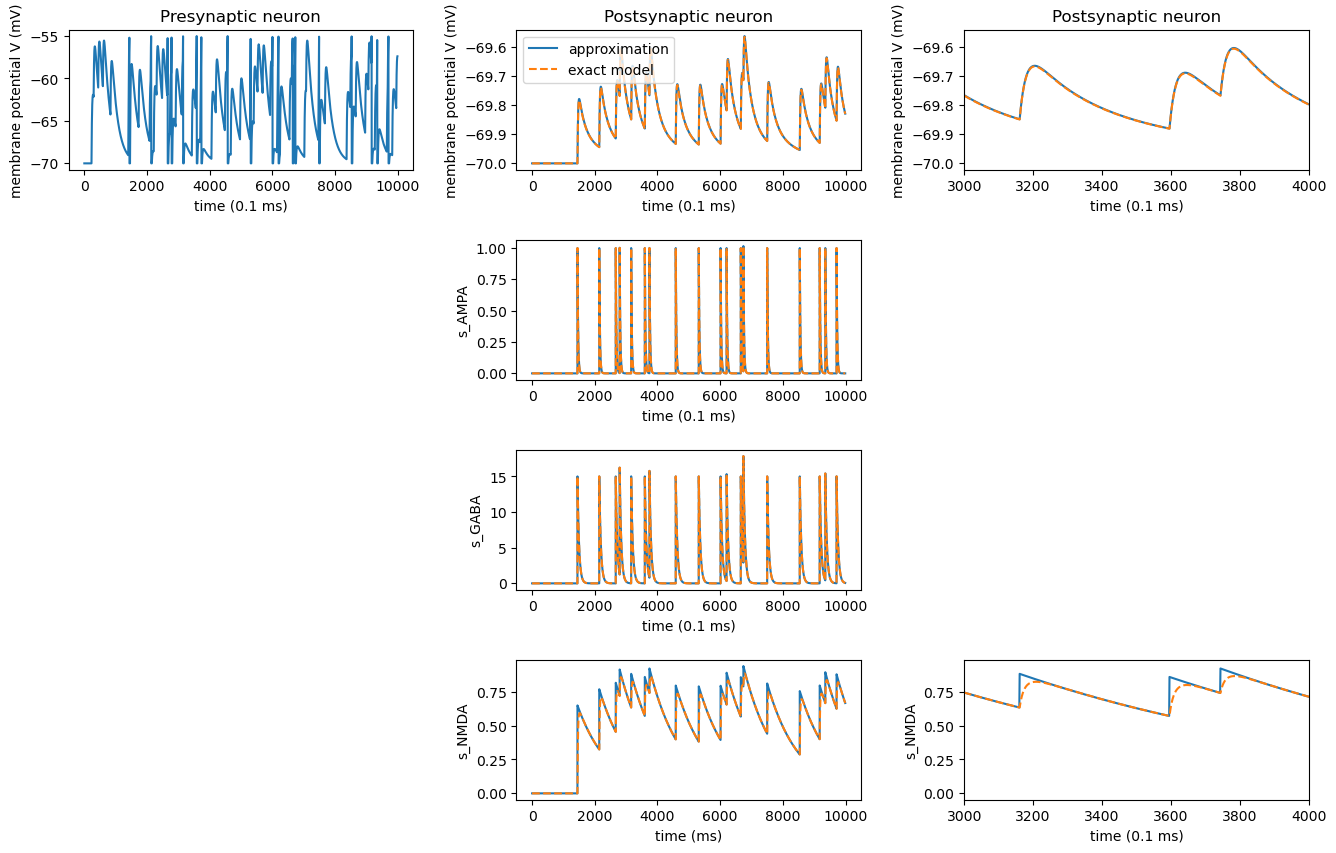

In [11]:
V_m = mm1.get("events", "V_m")
times = mm1.get("events", "times")
spikes = sr.get("events", "times") * nest.resolution

def s_soln(w, t, tau):
    isyn = np.zeros_like(t)
    useinds = t >= 0.
    isyn[useinds] = w * np.exp(-t[useinds] / tau)
    return isyn

fig, ax = plt.subplots(4,3)
fig.set_size_inches([16,10])
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax[0,0].plot(mm1.events["V_m"])
ax[0,0].set_xlabel("time (0.1 ms)")
ax[0,0].set_ylabel("membrane potential V (mV)")
ax[0,0].set_title("Presynaptic neuron")

ax[0,1].plot(mm2.events["V_m"], label="approximation")
ax[0,1].plot(mm3.events["V_m"], "--", label="exact model")
ax[0,1].set_xlabel("time (0.1 ms)")
ax[0,1].set_ylabel("membrane potential V (mV)")
ax[0,1].set_title("Postsynaptic neuron")
ax[0,1].legend()

ax[0,2].plot(mm2.events["V_m"], label="approximation")
ax[0,2].plot(mm3.events["V_m"], "--", label="exact model")
ax[0,2].set_xlabel("time (0.1 ms)")
ax[0,2].set_ylabel("membrane potential V (mV)")
ax[0,2].set_title("Postsynaptic neuron")
ax[0,2].set_xlim(3000, 4000)

ax[1,1].plot(mm2.events["s_AMPA"])
ax[1,1].plot(mm3.events["s_AMPA"], "--")
ax[1,1].set_xlabel("time (0.1 ms)")
ax[1,1].set_ylabel("s_AMPA")


ax[2,1].plot(mm2.events["s_GABA"])
ax[2,1].plot(mm3.events["s_GABA"], "--")
ax[2,1].set_xlabel("time (0.1 ms)")
ax[2,1].set_ylabel("s_GABA")


ax[3,1].plot(mm2.events["s_NMDA"])
ax[3,1].plot(mm3.events["s_NMDA"], "--")
ax[3,1].set_xlabel("time (ms)")
ax[3,1].set_ylabel("s_NMDA")

ax[3,2].plot(mm2.events["s_NMDA"])
ax[3,2].plot(mm3.events["s_NMDA"], "--")
ax[3,2].set_xlabel("time (0.1 ms)")
ax[3,2].set_ylabel("s_NMDA")
ax[3,2].set_xlim(3000, 4000)


ax[1,0].axis("off")
ax[2,0].axis("off")
ax[3,0].axis("off")
ax[1,2].axis("off")
ax[2,2].axis("off")


plt.show();